## Data AIS

In [1]:
#For 3.3.1
#Register Sedona Functions to Spark
from sedona.register import SedonaRegistrator
SedonaRegistrator.registerAll(spark)

True

In [2]:
#For 3.3.2
from shapely.geometry import Point, Polygon, mapping
import h3.api.numpy_int as h3int

In [3]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

In [4]:
# Path
base_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
path_unique = base_path + "212112409/"

In [5]:
# Read Data
data_ais = spark.read.parquet(path_unique + "ais-data-indonesia-2020.parquet")

## Eksplorasi

In [6]:
data_ais.count()

170083

In [7]:
data_ais.show()

+---------+-------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------------+----------+-------------+------+-----+------------------------------+----------------+--------------+--------------+-------+----+--------------------+--------+------------+----------------+--------------------+--------------------+------------------+--------+
|     mmsi|    imo|         longitude|            latitude|         dt_pos_utc|    H3_int_index_8|vessel_type|      ShiptypeLevel5|GrossTonnage|Deadweight|SummerDraught|length|width|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|draught| sog|          nav_status|Speedmax|Speedservice|            prov|              kabkot|                Port|       boundary_h3|position|
+---------+-------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------------+----------+-------------+------+-----+----------

In [4]:
from pyspark.sql.functions import col, expr, mean

# Daftar variabel yang akan dianalisis
variables = ["GrossTonnage", "Deadweight", "SummerDraught", "LengthBetweenPerpendicularsLBP", 
              "length", "width", "LengthOverallLOA", "BreadthMoulded","BreadthExtreme", "draught", "Speedmax", "Speedservice"]

# Fungsi untuk menghitung 5-number summary + rata-rata
def five_number_summary_with_mean(df, column):
    df.select(
        expr(f"percentile_approx({column}, 0) AS min"),
        expr(f"percentile_approx({column}, 0.25) AS Q1"),
        expr(f"percentile_approx({column}, 0.5) AS median"),
        expr(f"percentile_approx({column}, 0.75) AS Q3"),
        expr(f"percentile_approx({column}, 1) AS max"),
        mean(column).alias("mean")
    ).show(truncate=False)


In [9]:

# Menampilkan 5-number summary + rata-rata untuk setiap variabel
for var in variables:
    print(f"5-Number Summary + Mean for {var}:")
    five_number_summary_with_mean(data_ais, var)

5-Number Summary + Mean for GrossTonnage:
+---+----+------+-----+------+------------------+
|min|Q1  |median|Q3   |max   |mean              |
+---+----+------+-----+------+------------------+
|211|2810|5261  |14320|203997|11133.142318750257|
+---+----+------+-----+------+------------------+

5-Number Summary + Mean for Deadweight:
+---+----+------+-----+------+------------------+
|min|Q1  |median|Q3   |max   |mean              |
+---+----+------+-----+------+------------------+
|0  |3639|7052  |18010|403784|16369.953346307391|
+---+----+------+-----+------+------------------+

5-Number Summary + Mean for SummerDraught:
+---+---+------+---+-----+-----------------+
|min|Q1 |median|Q3 |max  |mean             |
+---+---+------+---+-----+-----------------+
|0.0|5.1|6.875 |9.0|23.04|7.295402809215721|
+---+---+------+---+-----+-----------------+

5-Number Summary + Mean for LengthBetweenPerpendicularsLBP:
+---+-----+------+-----+-------+----------------+
|min|Q1   |median|Q3   |max    |mean 

In [10]:
from pyspark.sql.functions import col, count, when

# Periksa jumlah nilai null untuk setiap kolom
for column in variables:
    null_count = data_ais.filter(col(column).isNull()).count()
    print(f"Kolom '{column}' memiliki {null_count} nilai null.")

Kolom 'GrossTonnage' memiliki 0 nilai null.
Kolom 'Deadweight' memiliki 0 nilai null.
Kolom 'SummerDraught' memiliki 0 nilai null.
Kolom 'LengthBetweenPerpendicularsLBP' memiliki 0 nilai null.
Kolom 'length' memiliki 3 nilai null.
Kolom 'width' memiliki 1 nilai null.
Kolom 'LengthOverallLOA' memiliki 0 nilai null.
Kolom 'BreadthMoulded' memiliki 0 nilai null.
Kolom 'BreadthExtreme' memiliki 0 nilai null.
Kolom 'draught' memiliki 0 nilai null.
Kolom 'Speedmax' memiliki 0 nilai null.
Kolom 'Speedservice' memiliki 0 nilai null.


In [11]:
from pyspark.sql.functions import col, countDistinct

# Cek apakah dalam setiap MMSI hanya ada satu nilai unik draught
mmsi_constant_draught = (
    data_ais.groupBy("mmsi")
    .agg(countDistinct("draught").alias("unique_draught_count"))
    .filter(col("unique_draught_count") == 1)  # Hanya ambil yang memiliki 1 nilai unik
    .select("mmsi")
)

# Hitung jumlah MMSI unik
count_mmsi_unique = mmsi_constant_draught.count()

# Ambil semua baris yang sesuai dengan MMSI tersebut
filtered_data = data_ais.join(mmsi_constant_draught, "mmsi", "inner")

# Hitung jumlah data pada data_ais yang memenuhi syarat
count_data_ais = filtered_data.count()

# Cetak hasil
print(f"Jumlah data_ais dengan draught konstan dalam satu MMSI: {count_data_ais}")
print(f"Jumlah MMSI unik dengan draught konstan: {count_mmsi_unique}")

Jumlah data_ais dengan draught konstan dalam satu MMSI: 5718
Jumlah MMSI unik dengan draught konstan: 104


In [12]:
# Hitung jumlah total MMSI unik yang memiliki lebih dari satu IMO
total_mmsi_multiple_imo = data_ais.groupBy("mmsi").agg(countDistinct("imo").alias("unique_imo_count"))
total_mmsi_multiple_imo_count = total_mmsi_multiple_imo.filter(col("unique_imo_count") > 1).count()

print(f"Total MMSI dengan lebih dari satu IMO: {total_mmsi_multiple_imo_count}")

Total MMSI dengan lebih dari satu IMO: 54


In [13]:
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col

columns_to_update = ["GrossTonnage", "Deadweight", "SummerDraught", "LengthBetweenPerpendicularsLBP", "LengthOverallLOA", "BreadthMoulded", "BreadthExtreme", "Speedmax", "Speedservice"]

for column in columns_to_update:
    mode_df = data_ais.groupBy("mmsi", column).count().withColumnRenamed("count", "cnt")
    
    # Gunakan Window yang diimpor dengan benar
    window_spec = Window.partitionBy("mmsi").orderBy(F.desc("cnt"))
    mode_df = mode_df.withColumn("rank", F.dense_rank().over(window_spec))
    mode_df = mode_df.filter(col("rank") == 1).drop("cnt", "rank")
    
    data_ais = data_ais.drop(column).join(mode_df, on=["mmsi"], how="left")

In [14]:
data_ais.show(truncate=False)

+---------+-------+------------------+------------------+-------------------+------------------+-----------+-------------------------+------+-----+-------+----+----------------------+----------------+-------------------+-------------------------------------+------------------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+
|mmsi     |imo    |longitude         |latitude          |dt_pos_utc         |H3_int_index_8    |vessel_type|ShiptypeLevel5           |length|width|draught|sog |nav_status            |prov            |kabkot             |Port                                 |boundary_h3       |position|GrossTonnage|Deadweight|SummerDraught|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|Speedmax|Speedservice|
+---------+-------+------------------+------------------+-------------------+------------------+-----------+-------------------------+------+-----+---

## Imputasi DWT

In [15]:
from pyspark.sql.functions import col, countDistinct

# Filter Deadweight == 0
filtered_data = data_ais.filter(col("Deadweight") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan Deadweight = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "Deadweight","LengthOverallLOA","BreadthMoulded","GrossTonnage","SummerDraught").distinct().show(n=100, truncate=False)

Jumlah record dengan Deadweight = 0: 690
Jumlah MMSI unik: 3
+---------+----------+----------------+--------------+------------+-------------+
|mmsi     |Deadweight|LengthOverallLOA|BreadthMoulded|GrossTonnage|SummerDraught|
+---------+----------+----------------+--------------+------------+-------------+
|525006134|0         |54.06           |14.0          |738         |2.84         |
|525018391|0         |38.3            |7.5           |214         |1.75         |
|525022370|0         |89.52           |13.5          |2003        |5.33         |
+---------+----------+----------------+--------------+------------+-------------+



In [16]:
from pyspark.sql.functions import min, max, col, when

# Menentukan kelas kapal berdasarkan Deadweight
data_ais = data_ais.withColumn("kelas_kapal", when((col("Deadweight") > 0) & (col("Deadweight") < 40000), "Handysize")
                               .when((col("Deadweight") >= 40000) & (col("Deadweight") < 60000), "Handymax")
                               .when((col("Deadweight") >= 60000) & (col("Deadweight") < 80000), "Panamax")
                               .when((col("Deadweight") >= 80000) & (col("Deadweight") < 120000), "Aframax")
                               .when((col("Deadweight") >= 120000) & (col("Deadweight") < 200000), "Suezmax")
                               .when((col("Deadweight") >= 200000) & (col("Deadweight") < 320000), "VLCC")
                               .when(col("Deadweight") >= 320000, "ULCC")
                               .otherwise("Unknown"))

# Menghitung nilai minimum dan maksimum GT untuk setiap kelas kapal
result = data_ais.groupBy("kelas_kapal").agg(
    min("GrossTonnage").alias("min_GT"),
    max("GrossTonnage").alias("max_GT")
).orderBy("min_GT")

# Menampilkan hasil
result.show()

+-----------+------+------+
|kelas_kapal|min_GT|max_GT|
+-----------+------+------+
|  Handysize|   211| 46555|
|    Unknown|   214|  2003|
|   Handymax| 21897| 50676|
|    Panamax| 40803|136894|
|    Aframax| 44387|136739|
|    Suezmax| 78845| 84214|
|       VLCC|113925|164680|
|       ULCC|160290|203997|
+-----------+------+------+



In [17]:
from pyspark.sql.functions import col, avg, min, max, when, broadcast, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import lead

# 1. Hitung rentang GrossTonnage dan avg_dwt untuk setiap kelas kapal (kecuali Unknown)
result = data_ais.filter((col("kelas_kapal") != "Unknown") & (col("Deadweight") > 0)) \
    .groupBy("kelas_kapal") \
    .agg(
        min("GrossTonnage").alias("min_GT"),
        max("GrossTonnage").alias("max_GT"),
        avg("Deadweight").alias("avg_dwt")  
    )

# Tentukan kelas_kapal dengan min_GT paling rendah
min_gt_global = result.select(min("min_GT")).collect()[0][0]

# Setel batas bawah min_GT paling rendah menjadi 0
result = result.withColumn(
    "min_GT", when(col("min_GT") == min_gt_global, lit(0)).otherwise(col("min_GT"))
)

# Menentukan batas atas rentang GT sebagai 1 angka sebelum min_GT di kelas selanjutnya
window_spec = Window.orderBy("min_GT")
result = result.withColumn("max_range_GT", lead("min_GT", 1).over(window_spec) - 1)
result = result.withColumn("max_range_GT", when(col("max_range_GT").isNull(), col("max_GT")).otherwise(col("max_range_GT")))

# 2. Gabungkan `result` ke `data_ais`, tetapi HANYA dengan kolom yang dibutuhkan
result = result.drop("kelas_kapal")  # Hapus kelas_kapal sebelum join agar tidak duplikat

imputed_dwt = data_ais.join(
    broadcast(result), 
    (col("GrossTonnage") >= col("min_GT")) & (col("GrossTonnage") <= col("max_range_GT")), 
    "left"
)

# 3. Imputasi Deadweight = 0 dengan rata-rata dari rentang yang sesuai
imputed_dwt = imputed_dwt.withColumn(
    "Deadweight",
    when((col("Deadweight") == 0) & col("avg_dwt").isNotNull(), col("avg_dwt"))
    .otherwise(col("Deadweight"))
)

# Hapus kolom tambahan yang tidak diperlukan setelah imputasi
imputed_dwt = imputed_dwt.drop("min_GT", "max_GT", "max_range_GT", "avg_dwt")

# Tampilkan hasil untuk verifikasi
imputed_dwt.filter(col("Deadweight") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|Speedmax|Speedservice|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+-----------+
+----+---+---------+--------+----------+--------------+-----------+------------

In [18]:
from pyspark.sql.functions import col

# Simpan data sebelum imputasi (data dengan draught = 0)
before_imputation = filtered_data.select("mmsi", "Deadweight")

# Gabungkan data sebelum imputasi dengan data setelah imputasi
comparison = before_imputation.join(imputed_dwt.select("mmsi", "Deadweight","GrossTonnage"), "mmsi", "inner")

# Tampilkan hasil perbandingan
comparison.withColumnRenamed("Deadweight", "Deadweight_before") \
          .withColumnRenamed("Deadweight", "Deadweight_after") \
          .show(n=100, truncate=False)

+---------+-----------------+------------------+------------+
|mmsi     |Deadweight_before|Deadweight_before |GrossTonnage|
+---------+-----------------+------------------+------------+
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|5250061

In [19]:
from pyspark.sql.functions import col, when, countDistinct

# 1️⃣ Menentukan kelas kapal berdasarkan Deadweight
imputed_dwt = imputed_dwt.withColumn(
    "kelas_kapal",
    when((col("Deadweight") > 0) & (col("Deadweight") < 40000), "Handysize")
    .when((col("Deadweight") >= 40000) & (col("Deadweight") < 60000), "Handymax")
    .when((col("Deadweight") >= 60000) & (col("Deadweight") < 80000), "Panamax")
    .when((col("Deadweight") >= 80000) & (col("Deadweight") < 120000), "Aframax")
    .when((col("Deadweight") >= 120000) & (col("Deadweight") < 200000), "Suezmax")
    .when((col("Deadweight") >= 200000) & (col("Deadweight") < 320000), "VLCC")
    .when(col("Deadweight") >= 320000, "ULCC")
    .otherwise("Unknown")
)

# 2️⃣ Menghitung jumlah unik MMSI untuk setiap kelas kapal
result = imputed_dwt.groupBy("kelas_kapal").agg(countDistinct("mmsi").alias("jumlah_kapal"))

# 3️⃣ Menampilkan hasil
result.show()

+-----------+------------+
|kelas_kapal|jumlah_kapal|
+-----------+------------+
|  Handysize|        1413|
|    Panamax|          58|
|    Suezmax|          18|
|   Handymax|         368|
|    Aframax|         101|
|       VLCC|          34|
|       ULCC|           8|
+-----------+------------+



## Imputasi Panjang & Lebar

In [20]:
# Ubah nama kolom di imputed_data
renamed_data = imputed_dwt \
    .withColumnRenamed("LengthBetweenPerpendicularsLBP", "LBP") \
    .withColumnRenamed("LengthOverallLOA", "LOA") \
    .withColumnRenamed("Speedservice", "speed")

In [21]:
renamed_data.show(5)

+---------+-------+------------------+-------------------+-------------------+------------------+-----------+--------------------+------+-----+-------+----+--------------------+--------------+------------------+--------------------+------------------+--------+------------+----------+-------------+-----+-----+--------------+--------------+--------+-----+-----------+
|     mmsi|    imo|         longitude|           latitude|         dt_pos_utc|    H3_int_index_8|vessel_type|      ShiptypeLevel5|length|width|draught| sog|          nav_status|          prov|            kabkot|                Port|       boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|  LBP|  LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+---------+-------+------------------+-------------------+-------------------+------------------+-----------+--------------------+------+-----+-------+----+--------------------+--------------+------------------+--------------------+------------------+--------+----

In [22]:
from pyspark.sql.functions import col, countDistinct

# Filter LBP == 0
filtered_data = renamed_data.filter(col("LBP") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan LBP = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","LBP","LOA","length").distinct().show(n=100, truncate=False)

Jumlah record dengan LBP = 0: 2905
Jumlah MMSI unik: 11
+---------+---+-----+------+
|mmsi     |LBP|LOA  |length|
+---------+---+-----+------+
|525119035|0.0|0.0  |90.0  |
|525200402|0.0|76.29|76.0  |
|525010322|0.0|58.2 |60.0  |
|677042300|0.0|73.03|0.0   |
|525119034|0.0|0.0  |90.0  |
|525100306|0.0|79.8 |0.0   |
|525100306|0.0|79.8 |90.0  |
|525100306|0.0|79.8 |80.0  |
|525100306|0.0|79.8 |79.0  |
|525200523|0.0|0.0  |0.0   |
|374746000|0.0|88.28|82.0  |
|525023236|0.0|74.68|75.0  |
|525100438|0.0|79.8 |74.0  |
|525021305|0.0|88.28|88.0  |
+---------+---+-----+------+



In [23]:
from pyspark.sql.functions import col, countDistinct

# Filter BreadthMoulded == 0
filtered_data = renamed_data.filter(col("BreadthMoulded") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan BreadthMoulded = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","BreadthMoulded","BreadthExtreme","width").distinct().show(n=100, truncate=False)

Jumlah record dengan BreadthMoulded = 0: 249
Jumlah MMSI unik: 3
+---------+--------------+--------------+-----+
|mmsi     |BreadthMoulded|BreadthExtreme|width|
+---------+--------------+--------------+-----+
|525007030|0.0           |15.0          |14.0 |
|525200402|0.0           |0.0           |18.0 |
|525021181|0.0           |15.0          |16.0 |
|525021181|0.0           |15.0          |14.0 |
+---------+--------------+--------------+-----+



In [24]:
from pyspark.sql import functions as F

# Step 1: Isi LBP dengan LOA jika LBP == 0 dan LOA > 0, jika masih 0 cek length
imputed_data = renamed_data.withColumn(
    "LBP",
    F.when((F.col("LBP") == 0) & (F.col("LOA") > 0), F.col("LOA"))
    .when((F.col("LBP") == 0) & (F.col("length") > 0), F.col("length"))
    .otherwise(F.col("LBP"))
)

# Step 2: Hitung rata-rata LBP berdasarkan kelas_kapal (hanya untuk LBP > 0)
avg_LBP = (
    imputed_data.filter(F.col("LBP") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("LBP").alias("avg_LBP"))
)

# Step 3: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data = imputed_data.alias("a").join(
    avg_LBP.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_LBP")  # Ambil hanya avg_LBP dari avg_LBP dataset
)

# Step 4: Isi LBP dengan rata-rata jika LBP, LOA, dan length semuanya nol
imputed_data = imputed_data.withColumn(
    "LBP",
    F.when(
        (F.col("LBP") == 0) & (F.col("LOA") == 0) & (F.col("length") == 0),
        F.col("avg_LBP")
    ).otherwise(F.col("LBP"))
)

# Step 5: Hapus kolom avg_LBP setelah digunakan agar dataset tetap bersih
imputed_data = imputed_data.drop("avg_LBP")

# Step 6: Cek apakah masih ada LBP yang bernilai 0 setelah imputasi
imputed_data.filter(F.col("LBP") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

In [25]:
from pyspark.sql import functions as F

# Step 1: Isi BreadthMoulded dengan BreadthExtreme jika BreadthMoulded == 0, jika masih 0 cek width
imputed_data_ais = imputed_data.withColumn(
    "BreadthMoulded",
    F.when((F.col("BreadthMoulded") == 0) & (F.col("BreadthExtreme") > 0), F.col("BreadthExtreme"))
    .when((F.col("BreadthMoulded") == 0) & (F.col("width") > 0), F.col("width"))
    .otherwise(F.col("BreadthMoulded"))
)

# Step 2: Hitung rata-rata BreadthMoulded berdasarkan kelas_kapal (hanya untuk BreadthMoulded > 0)
avg_BreadthMoulded = (
    imputed_data_ais.filter(F.col("BreadthMoulded") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("BreadthMoulded").alias("avg_BreadthMoulded"))
)

# Step 3: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data_ais = imputed_data_ais.alias("a").join(
    avg_BreadthMoulded.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_BreadthMoulded")  # Ambil hanya avg_BreadthMoulded dari avg_BreadthMoulded dataset
)

# Step 4: Isi BreadthMoulded dengan rata-rata jika BreadthMoulded, BreadthExtreme, dan width semuanya nol
imputed_data_ais = imputed_data_ais.withColumn(
    "BreadthMoulded",
    F.when(
        (F.col("BreadthMoulded") == 0) & (F.col("BreadthExtreme") == 0) & (F.col("width") == 0),
        F.col("avg_BreadthMoulded")
    ).otherwise(F.col("BreadthMoulded"))
)

# Step 5: Hapus kolom avg_BreadthMoulded setelah digunakan agar dataset tetap bersih
imputed_data_LB = imputed_data_ais.drop("avg_BreadthMoulded")

# Step 6: Cek apakah masih ada BreadthMoulded yang bernilai 0 setelah imputasi
imputed_data_LB.filter(F.col("BreadthMoulded") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

In [26]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112409/"

In [27]:
#save as parquet
imputed_data_LB.write.option("header",True).mode("overwrite").parquet(save_path_unique + "ais-data-imputed-2020.parquet")

## Imputasi Speedservice

In [5]:
# Path
base_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
path_unique = base_path + "212112409/"

In [6]:
# Read Data
imputed_data_LB = spark.read.parquet(path_unique + "ais-data-imputed-2020.parquet")

In [7]:
imputed_data_LB.count()

170083

In [8]:
from pyspark.sql.functions import col, countDistinct

# Filter speed == 0
filtered_data = imputed_data_LB.filter(col("speed") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan speed = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "speed", "Speedmax", "kelas_kapal").distinct().show(n=100, truncate=False)

Jumlah record dengan speed = 0: 9869
Jumlah MMSI unik: 75
+---------+-----+--------+-----------+
|mmsi     |speed|Speedmax|kelas_kapal|
+---------+-----+--------+-----------+
|371219000|0.0  |0.0     |Handysize  |
|525015322|0.0  |0.0     |Handysize  |
|525018194|0.0  |0.0     |Handysize  |
|525007314|0.0  |0.0     |Handysize  |
|525018198|0.0  |0.0     |Handysize  |
|525006037|0.0  |0.0     |Handysize  |
|525200402|0.0  |0.0     |Handysize  |
|525019557|0.0  |0.0     |Handysize  |
|525010062|0.0  |0.0     |Handysize  |
|567070500|0.0  |0.0     |Handysize  |
|525100242|0.0  |0.0     |Handysize  |
|525024245|0.0  |0.0     |Handysize  |
|525007119|0.0  |0.0     |Handysize  |
|525022272|0.0  |0.0     |Handysize  |
|525100077|0.0  |0.0     |Handysize  |
|525018195|0.0  |0.0     |Handysize  |
|533000313|0.0  |0.0     |Handysize  |
|525100679|0.0  |0.0     |Handysize  |
|525022679|0.0  |10.0    |Handysize  |
|525021118|0.0  |0.0     |Handysize  |
|525018252|0.0  |0.0     |Handysize  |
|58252

In [9]:
from pyspark.sql import functions as F

# Step 1: Hitung rata-rata speed berdasarkan kelas_kapal (hanya untuk speed > 0)
avg_speed = (
    imputed_data_LB.filter(F.col("speed") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("speed").alias("avg_speed"))
)

# Step 2: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data_LB = imputed_data_LB.alias("a").join(
    avg_speed.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_speed").alias("avg_speed")  # Ambil avg_speed dari avg_speed dataset dengan alias eksplisit
)

# Step 3: Imputasi speed dengan kondisi
imputed_data_LB = imputed_data_LB.withColumn(
    "speed",
    F.when(
        (F.col("speed") == 0) & (F.col("Speedmax") != 0), F.col("Speedmax")
    ).when(
        (F.col("speed") == 0), F.col("avg_speed")
    ).otherwise(F.col("speed"))
)

# Step 4: Hapus kolom avg_speed setelah digunakan
imputed_speed = imputed_data_LB.drop("avg_speed")

# Step 5: Cek apakah masih ada speed yang bernilai 0 setelah imputasi
imputed_speed.filter(F.col("speed") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

## Bentuk Designed Block Coefficient

In [10]:
from pyspark.sql.functions import col, sqrt, when

imputed_cbd = imputed_speed.withColumn(
    "cbdesign",
    when(col("vessel_type") == "Cargo", 1 - 0.234 * (col("speed") / sqrt(col("LBP"))))
    .when((col("vessel_type") == "Tanker") & (col("deadweight") < 50000), 1 - 0.195 * (col("speed") / sqrt(col("LBP"))))
    .when((col("vessel_type") == "Tanker") & (col("deadweight") >= 50000), 1 - 0.182 * (col("speed") / sqrt(col("LBP"))))
)

imputed_cbd.show(truncate=False)

+---------+-------+------------------+------------------+-------------------+------------------+-----------+----------------+------+-----+-------+----+----------------------+--------------+-------------------+------------------------+------------------+--------+------------+----------+-------------+-----+-----+--------------+--------------+--------+-----+-----------+------------------+
|mmsi     |imo    |longitude         |latitude          |dt_pos_utc         |H3_int_index_8    |vessel_type|ShiptypeLevel5  |length|width|draught|sog |nav_status            |prov          |kabkot             |Port                    |boundary_h3       |position|GrossTonnage|Deadweight|SummerDraught|LBP  |LOA  |BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|cbdesign          |
+---------+-------+------------------+------------------+-------------------+------------------+-----------+----------------+------+-----+-------+----+----------------------+--------------+-------------------+-------------

In [11]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Payload:")
five_number_summary_with_mean(imputed_cbd, "cbdesign")

5-Number Summary + Mean for Payload:
+-----------------+------------------+------------------+------------------+------------------+------------------+
|min              |Q1                |median            |Q3                |max               |mean              |
+-----------------+------------------+------------------+------------------+------------------+------------------+
|0.553981217146261|0.7385347140733959|0.7575655098794728|0.7815084819077389|0.8797747568482014|0.7587447900806452|
+-----------------+------------------+------------------+------------------+------------------+------------------+



## Periksa Summer Draught

In [12]:
from pyspark.sql.functions import col, countDistinct

# Filter SummerDraught == 0
filtered_data = imputed_cbd.filter(col("SummerDraught") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan SummerDraught = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","Deadweight","LBP","BreadthMoulded","GrossTonnage","SummerDraught").distinct().show(n=100, truncate=False)

Jumlah record dengan SummerDraught = 0: 4692
Jumlah MMSI unik: 21
+---------+----------+-----+--------------+------------+-------------+
|mmsi     |Deadweight|LBP  |BreadthMoulded|GrossTonnage|SummerDraught|
+---------+----------+-----+--------------+------------+-------------+
|525119034|2200.0    |90.0 |15.0          |2432        |0.0          |
|525015818|500.0     |44.0 |8.0           |313         |0.0          |
|525023356|2250.0    |58.2 |16.0          |1148        |0.0          |
|525023236|5791.0    |74.68|19.5          |2180        |0.0          |
|525300475|1000.0    |53.19|12.0          |664         |0.0          |
|525019637|2500.0    |74.5 |15.24         |1222        |0.0          |
|525010327|3915.0    |72.32|18.0          |1997        |0.0          |
|525010168|3540.0    |84.07|20.0          |2370        |0.0          |
|525021305|3500.0    |88.28|15.0          |1975        |0.0          |
|525006108|1900.0    |70.0 |11.2          |995         |0.0          |
|677042300|

In [13]:
# Buat df baru dengan rename kolom
renamed_cbd = imputed_cbd.withColumnRenamed("SummerDraught", "dmax") \
                              .withColumnRenamed("draught", "dreported")

# Tampilkan skema untuk memastikan perubahan
renamed_cbd.printSchema()

root
 |-- mmsi: integer (nullable = true)
 |-- imo: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- H3_int_index_8: long (nullable = true)
 |-- vessel_type: string (nullable = true)
 |-- ShiptypeLevel5: string (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- dreported: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- nav_status: string (nullable = true)
 |-- prov: string (nullable = true)
 |-- kabkot: string (nullable = true)
 |-- Port: string (nullable = true)
 |-- boundary_h3: long (nullable = true)
 |-- position: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: double (nullable = true)
 |-- dmax: double (nullable = true)
 |-- LBP: double (nullable = true)
 |-- LOA: double (nullable = true)
 |-- BreadthMoulded: double (nullable = true)
 |-- BreadthExtreme: double (nullable = 

In [14]:
from pyspark.sql.functions import col, sqrt, when, max

# Cari nilai dreported tertinggi untuk setiap mmsi
max_dreported = renamed_cbd.groupBy("mmsi").agg(max("dreported").alias("max_dreported"))

# Gabungkan dengan data asli dan perbarui dmax jika lebih kecil dari max_dreported
imputed_sd = renamed_cbd.join(max_dreported, on="mmsi", how="left").withColumn(
    "dmax", when(col("dmax") < col("max_dreported"), col("max_dreported")).otherwise(col("dmax"))
).drop("max_dreported")

# Cek hasil dengan memfilter jika masih ada dmax < dreported
imputed_sd.filter(col("dmax") < col("dreported")).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+--------------+--------+-----+-----------+--------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|dreported|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|dmax|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|cbdesign|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+--------------+--------+-----+-----------+--------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+----

In [15]:
from pyspark.sql.functions import col

# Simpan data sebelum imputasi (data dengan draught = 0)
before_imputation = filtered_data.select("mmsi", "summerdraught")

# Gabungkan data sebelum imputasi dengan data setelah imputasi
comparison = before_imputation.join(imputed_sd.select("mmsi", "dmax"), "mmsi", "inner")

# Tampilkan hasil perbandingan
comparison.withColumnRenamed("summerdraught", "draught_before") \
          .withColumnRenamed("dmax", "draught_after") \
          .show(truncate=False)

+---------+--------------+-------------+
|mmsi     |draught_before|draught_after|
+---------+--------------+-------------+
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
|525006108|0.0           |4.6          |
+---------+--------------+-------------+
only showing top

In [16]:
# Tampilkan hasil untuk verifikasi
imputed_sd.filter(F.col("dmax") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+--------------+--------+-----+-----------+--------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|dreported|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|dmax|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|cbdesign|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+--------------+--------+-----+-----------+--------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+---------+---+----------+----+------+----+-----------+--------+------------+----------+----+---+---+--------------+----

In [ ]:
from pyspark.sql.functions import col, avg, when

# Mapping pertama: Imputasi berdasarkan Deadweight
mapping_df_deadweight = (
    imputed_sd.filter(col("dmax") > 0)
    .groupBy("Deadweight")
    .agg(avg("dmax").alias("avg_SummerDraught_dw"))
)

# Mapping kedua: Imputasi berdasarkan cbdesign
mapping_df_cbdesign = (
    imputed_sd.filter(col("dmax") > 0)
    .groupBy("cbdesign")
    .agg(avg("dmax").alias("avg_SummerDraught_cb"))
)

# Mapping ketiga: Imputasi berdasarkan kelas_kapal
mapping_df_kelas_kapal = (
    imputed_sd.filter(col("dmax") > 0)
    .groupBy("kelas_kapal")
    .agg(avg("dmax").alias("avg_SummerDraught_kelas"))
)

# Gabungkan semua mapping ke data utama
imputed_data_ais = (
    imputed_sd
    # Join dengan mapping Deadweight
    .join(mapping_df_deadweight, "Deadweight", "left")
    # Join dengan mapping cbdesign
    .join(mapping_df_cbdesign, "cbdesign", "left")
    # Join dengan mapping kelas_kapal
    .join(mapping_df_kelas_kapal, "kelas_kapal", "left")
    # Imputasi bertahap
    .withColumn(
        "dmax",
        when(col("dmax") == 0,
            when(col("avg_SummerDraught_dw").isNotNull(), col("avg_SummerDraught_dw"))
            .otherwise(
                when(col("avg_SummerDraught_cb").isNotNull(), col("avg_SummerDraught_cb"))
                .otherwise(col("avg_SummerDraught_kelas"))
            )
        ).otherwise(col("dmax"))
    )
    # Hapus kolom tambahan setelah imputasi selesai
    .drop("avg_SummerDraught_dw", "avg_SummerDraught_cb", "avg_SummerDraught_kelas")
)

# Tampilkan hasil untuk verifikasi
imputed_data_ais.filter(F.col("dmax") == 0).show(truncate=False)

In [17]:
imputed_data_ais = imputed_sd

## Bentuk Reported Block Coefficient

In [18]:
from pyspark.sql.functions import col, pow, lit, when

# Membuat kolom cbreported dengan rumus yang benar
imputed_data_ais = imputed_data_ais.withColumn(
    "cbreported",
    when(
        col("dreported") >= 1,  # Menghindari pembagian dengan 0
        lit(1) - ((lit(1) - col("cbdesign")) * pow((col("dmax") / col("dreported")), lit(1) / 3))
    ).otherwise(1)  # Isi 1 jika dreported tidak valid
)

# Tampilkan beberapa data untuk verifikasi
imputed_data_ais.select("cbdesign", "dmax", "dreported", "cbreported").show()

+-----------------+------+---------+------------------+
|         cbdesign|  dmax|dreported|        cbreported|
+-----------------+------+---------+------------------+
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908791215|
|0.833786806985983|14.798|      8.5|0.8000474908

In [19]:
print(f"5-Number Summary + Mean:")
five_number_summary_with_mean(imputed_data_ais, "cbreported")

5-Number Summary + Mean:
+------------------+------------------+------------------+------------------+---+------------------+
|min               |Q1                |median            |Q3                |max|mean              |
+------------------+------------------+------------------+------------------+---+------------------+
|0.3069024997026427|0.7135428990075261|0.7388280607231092|0.7626617016801873|1.0|0.7427284547157555|
+------------------+------------------+------------------+------------------+---+------------------+



In [20]:
from pyspark.sql.functions import col, count

# Hitung jumlah berdasarkan kondisi
count_cbdesign_less = imputed_data_ais.filter(col("cbdesign") < col("cbreported")).count()
count_cbdesign_equal = imputed_data_ais.filter(col("cbdesign") == col("cbreported")).count()
count_cbdesign_greater = imputed_data_ais.filter(col("cbdesign") > col("cbreported")).count()

# Tampilkan hasil
print(f"Jumlah cbdesign < cbreported: {count_cbdesign_less}")
print(f"Jumlah cbdesign = cbreported: {count_cbdesign_equal}")
print(f"Jumlah cbdesign > cbreported: {count_cbdesign_greater}")

Jumlah cbdesign < cbreported: 5493
Jumlah cbdesign = cbreported: 15673
Jumlah cbdesign > cbreported: 148917


## Hitung Payload

In [21]:
from pyspark.sql.functions import col, lit, when

# Definisikan densitas air laut
rho_w = 1.025

# Tambahkan kolom payload dengan memastikan nilai minimum adalah 0
data_ais_payload = imputed_data_ais.withColumn(
    "payload",
        ((col("cbreported") * col("dreported") - col("cbdesign") * col("dmax")) * 
         col("LBP") * col("BreadthMoulded") * lit(rho_w) + col("deadweight")) / col("deadweight")
)

# Tampilkan hasil untuk verifikasi
data_ais_payload.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", 
    "LBP", "BreadthMoulded", "deadweight", "payload"
).show(n=100, truncate=False)

+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+
|mmsi     |cbreported        |cbdesign         |dreported|dmax  |LBP  |BreadthMoulded|deadweight|payload            |
+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5     

In [22]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Payload:")
five_number_summary_with_mean(data_ais_payload, "payload")

5-Number Summary + Mean for Payload:
+------------------+------------------+------------------+------------------+---+------------------+
|min               |Q1                |median            |Q3                |max|mean              |
+------------------+------------------+------------------+------------------+---+------------------+
|-6.354037720830804|0.4908260509398423|0.6742091228312731|0.8909524431676134|1.0|0.5336783068832647|
+------------------+------------------+------------------+------------------+---+------------------+



In [23]:
# Menampilkan 5-number summary + rata-rata untuk payload yang < 0
print("5-Number Summary + Mean for Payload (payload < 0):")
five_number_summary_with_mean(data_ais_payload.filter(col("payload") < 0), "payload")

5-Number Summary + Mean for Payload (payload < 0):
+------------------+-------------------+-------------------+-------------------+----------------------+-------------------+
|min               |Q1                 |median             |Q3                 |max                   |mean               |
+------------------+-------------------+-------------------+-------------------+----------------------+-------------------+
|-6.354037720830804|-2.6169900267672115|-1.2514389401085135|-0.5062258122559323|-0.0038503880890543287|-1.8535823376602585|
+------------------+-------------------+-------------------+-------------------+----------------------+-------------------+



In [24]:
from pyspark.sql.functions import col

# Hitung jumlah record dengan payload < 0
count_payload_negative = data_ais_payload.filter(col("payload") < 0).count()
print(f"Jumlah record dengan payload < 0: {count_payload_negative}")

# Hitung jumlah record dengan payload > 1
count_payload_above_one = data_ais_payload.filter(col("payload") > 1).count()
print(f"Jumlah record dengan payload > 1: {count_payload_above_one}")

# Hitung jumlah record dengan payload antara 0 dan 1 (inklusif)
count_payload_zero_to_one = data_ais_payload.filter((col("payload") >= 0) & (col("payload") <= 1)).count()
print(f"Jumlah record dengan payload antara 0 dan 1: {count_payload_zero_to_one}")

Jumlah record dengan payload < 0: 11132
Jumlah record dengan payload > 1: 0
Jumlah record dengan payload antara 0 dan 1: 158951


## Imputasi Payload Negatif

In [25]:
from pyspark.sql.functions import col, when

# Tambahkan kolom baru "payload_new" dengan nilai minimum 0
imputed_payload = data_ais_payload.withColumn(
    "payload_new",
    when(col("payload") < 0, 0).otherwise(col("payload"))
)

# Tampilkan hasil untuk verifikasi
imputed_payload.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", 
    "LBP", "BreadthMoulded", "deadweight", "payload", "payload_new"
).show(n=100, truncate=False)

+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+-------------------+
|mmsi     |cbreported        |cbdesign         |dreported|dmax  |LBP  |BreadthMoulded|deadweight|payload            |payload_new        |
+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+-------------------+
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |0.4746714169819886 |
|525800206|0.8000474908791215|0.83

In [26]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Payload:")
five_number_summary_with_mean(imputed_payload, "payload_new")

5-Number Summary + Mean for Payload:
+---+------------------+------------------+------------------+---+------------------+
|min|Q1                |median            |Q3                |max|mean              |
+---+------------------+------------------+------------------+---+------------------+
|0.0|0.4908260509398423|0.6742091228312731|0.8909524431676134|1.0|0.6549960081399188|
+---+------------------+------------------+------------------+---+------------------+



In [27]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = data_ais_payload.select("payload").toPandas()

generated new fontManager


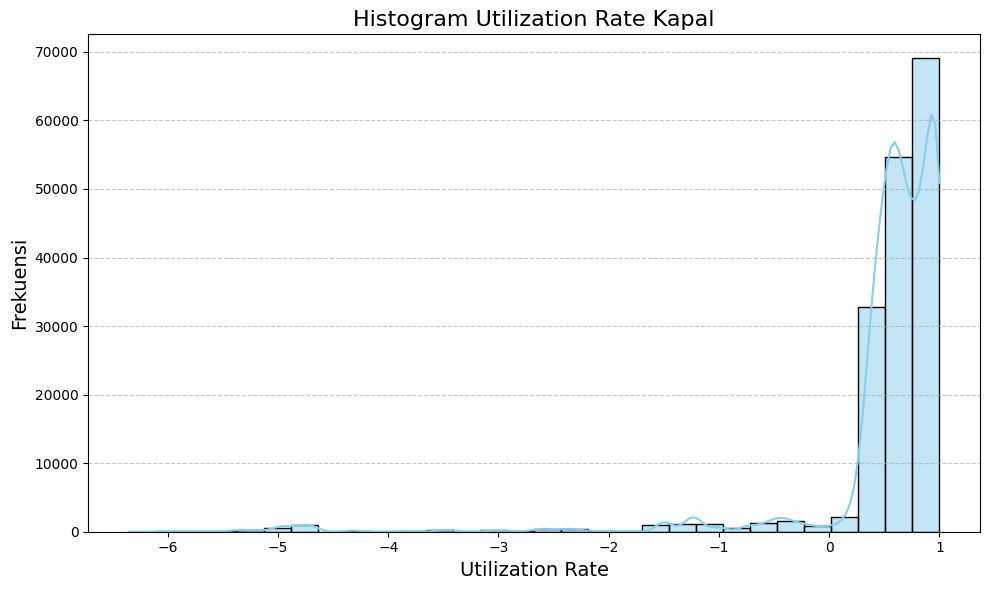

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["payload"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Utilization Rate Kapal', fontsize=16)
plt.xlabel('Utilization Rate', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

In [29]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = imputed_payload.select("payload_new").toPandas()

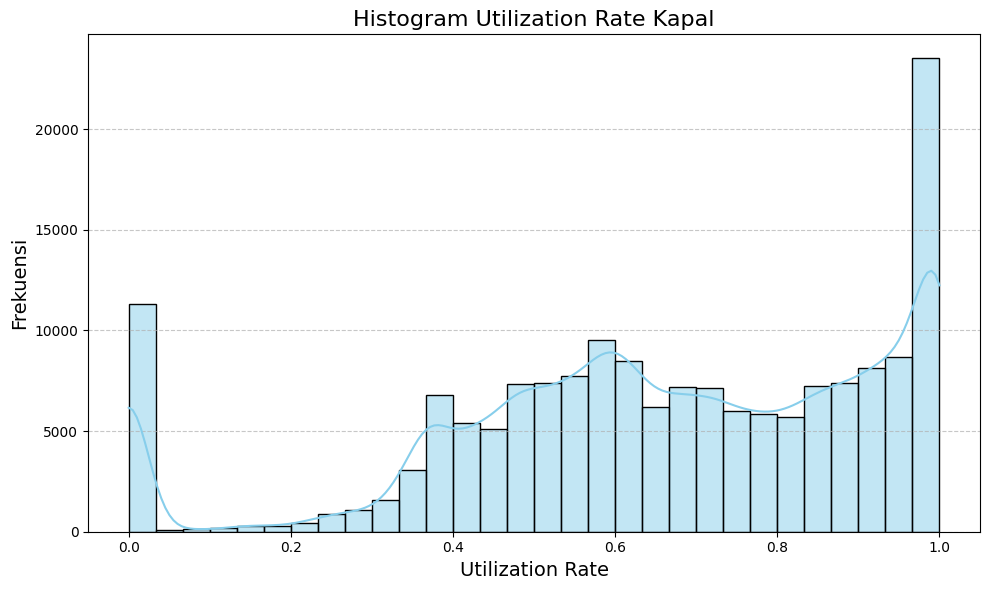

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["payload_new"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Utilization Rate Kapal', fontsize=16)
plt.xlabel('Utilization Rate', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

## Simpan Data

In [31]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112409/"

In [32]:
#save as parquet
data_ais_payload.write.option("header",True).mode("overwrite").parquet(save_path_unique + "ais-data-ur-2020.parquet")

## Hitung Displacement

In [33]:
from pyspark.sql.functions import col

# Konstanta ρ (rho)
rho = 1.025

# Tambahkan kolom "disp"
data_ais_displacement = imputed_payload.withColumn(
    "displacement",
    rho * col("LBP") * col("BreadthMoulded") * col("dreported") * col("cbdesign")
)

# Tampilkan hasil untuk verifikasi
data_ais_displacement.select(
    "mmsi", "cbdesign", "dreported", "LBP", "BreadthMoulded", "displacement"
).show(n=1000, truncate=False)

+---------+------------------+---------+-------+--------------+------------------+
|mmsi     |cbdesign          |dreported|LBP    |BreadthMoulded|displacement      |
+---------+------------------+---------+-------+--------------+------------------+
|240892000|0.8215343170242526|8.6      |234.0  |42.0          |71172.65614490204 |
|240892000|0.8215343170242526|8.6      |234.0  |42.0          |71172.65614490204 |
|240892000|0.8215343170242526|8.6      |234.0  |42.0          |71172.65614490204 |
|240892000|0.8215343170242526|11.1     |234.0  |42.0          |91862.38176842005 |
|240892000|0.8215343170242526|11.1     |234.0  |42.0          |91862.38176842005 |
|240892000|0.8215343170242526|11.1     |234.0  |42.0          |91862.38176842005 |
|240892000|0.8215343170242526|11.0     |234.0  |42.0          |91034.79274347934 |
|240892000|0.8215343170242526|11.0     |234.0  |42.0          |91034.79274347934 |
|240892000|0.8215343170242526|11.0     |234.0  |42.0          |91034.79274347934 |
|240

In [34]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Displacement:")
five_number_summary_with_mean(data_ais_displacement, "displacement")

5-Number Summary + Mean for Displacement:
+---+---------------+-----------------+------------------+-----------------+------------------+
|min|Q1             |median           |Q3                |max              |mean              |
+---+---------------+-----------------+------------------+-----------------+------------------+
|0.0|4482.9058540848|8098.197115114191|18727.057086370354|376328.7690361449|16196.599187858468|
+---+---------------+-----------------+------------------+-----------------+------------------+



In [35]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = data_ais_displacement.select("displacement").toPandas()

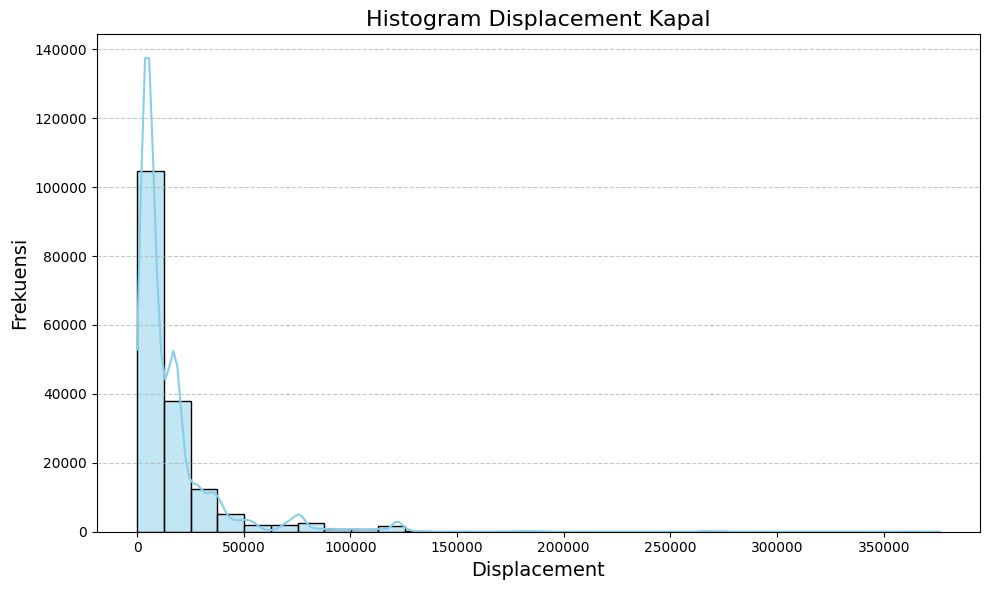

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["displacement"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Displacement Kapal', fontsize=16)
plt.xlabel('Displacement', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

In [37]:
from pyspark.sql.functions import col

# Filter data dengan displacement = 0 dan hitung jumlahnya
data_ais_displacement.filter(col("displacement") == 0).count()

5175

In [38]:
from pyspark.sql.functions import col, when

# Konstanta ρ (rho)
rho = 1.025

# Tambahkan kolom "displacement_new" dengan kondisi jika dreported == 0 maka gunakan dmax
data_ais_displacement = data_ais_displacement.withColumn(
    "displacement_new",
    rho * col("LBP") * col("BreadthMoulded") * when(
        col("dreported") == 0, col("dmax")
    ).otherwise(col("dreported")) * col("cbdesign")
)

# Tampilkan hasil untuk verifikasi
data_ais_displacement.select(
    "mmsi", "displacement", "displacement_new"
).filter(col("displacement") == 0).show(n=1000, truncate=False)

+---------+------------+------------------+
|mmsi     |displacement|displacement_new  |
+---------+------------+------------------+
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|538008499|0.0         |60978.94456415544 |
|525100679|0.0         |2788.1310516028075|
|525007030|0.0         |5012.062987404496 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591738319629 |
|525019324|0.0         |3183.591

In [39]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Displacement:")
five_number_summary_with_mean(data_ais_displacement, "displacement_new")

5-Number Summary + Mean for Displacement:
+------------------+-----------------+----------------+-----------------+-----------------+-----------------+
|min               |Q1               |median          |Q3               |max              |mean             |
+------------------+-----------------+----------------+-----------------+-----------------+-----------------+
|122.87782036387416|4659.924653699601|8411.59559977359|18978.95925182337|467719.4866032895|16546.82960815211|
+------------------+-----------------+----------------+-----------------+-----------------+-----------------+



In [40]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = data_ais_displacement.select("displacement_new").toPandas()

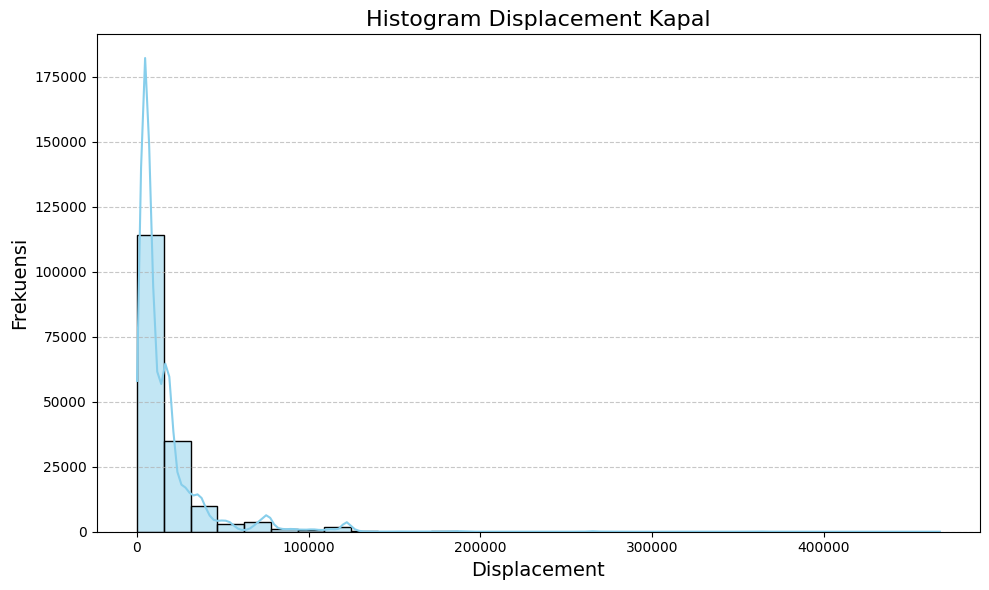

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["displacement_new"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Displacement Kapal', fontsize=16)
plt.xlabel('Displacement', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

## Simpan Data

In [48]:
data_ais_displacement.printSchema()

root
 |-- mmsi: integer (nullable = true)
 |-- imo: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- H3_int_index_8: long (nullable = true)
 |-- vessel_type: string (nullable = true)
 |-- ShiptypeLevel5: string (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- dreported: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- nav_status: string (nullable = true)
 |-- prov: string (nullable = true)
 |-- kabkot: string (nullable = true)
 |-- Port: string (nullable = true)
 |-- boundary_h3: long (nullable = true)
 |-- position: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: double (nullable = true)
 |-- dmax: double (nullable = true)
 |-- LBP: double (nullable = true)
 |-- LOA: double (nullable = true)
 |-- BreadthMoulded: double (nullable = true)
 |-- BreadthExtreme: double (nullable = 

In [42]:
data_ais_displacement = data_ais_displacement.select("mmsi", "imo", "longitude", "latitude", "dt_pos_utc",
                                                    "vessel_type", "ShiptypeLevel5", "prov", "kabkot",
                                                    "Port", "kelas_kapal", "payload", "payload_new", "displacement", "displacement_new")

In [43]:
#save as parquet
data_ais_displacement.write.option("header",True).mode("overwrite").parquet(save_path_unique + "ais-data-displacement-2020.parquet")

In [44]:
spark.stop()

Error occurred while attempting Spark job cancellation when interrupting the kernel: 'NoneType' object has no attribute 'sc'
